In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import csv
import IPython.display as display

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

# Notebook two: Preprocessing and training
Create a new notebook for this. At the start, download your starter CSV and thumbnails.zip.

The starter code below assumes you have created a zip file called "thumbnails.zip" containing only the resized images from the COOC training set mentioned in the starter CSV, and that you can download it from a URL.

In [0]:
colab_root = "/content/" 

### Download the starter CSV

In [0]:
csv_path = os.path.join(colab_root, "starter.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter.csv",
                     csv_path)

9084928/9078552 [==============================] - 0s 0us/step


'/content/starter.csv'

In [0]:
YOUR_THUMBNAILS_URL = 'https://storage.cloud.google.com/adl_hw4_cl/thumbnails.zip?organizationId=819335046878'

In [0]:
thumbnails_file = os.path.join(colab_root, "thumbnails.zip")
download_if_missing('https://storage.cloud.google.com/adl_hw4_cl/thumbnails.zip?organizationId=819335046878', thumbnails_file)

'/content/thumbnails.zip'

In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/adl_data/thumbnails.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/thumbnails/')

In [0]:
!unzip -q /content/thumbnails.zip -d /content/image_folder_2

In [0]:
! ls -lha
! du -sh

total 2.4M
drwxr-xr-x 1 root root 4.0K Nov 20 18:25 .
drwxr-xr-x 1 root root 4.0K Nov 20 18:11 ..
drwxr-xr-x 1 root root 4.0K Nov 18 16:15 .config
drwx------ 4 root root 4.0K Nov 20 18:25 drive
drwxr-xr-x 1 root root 4.0K Nov 15 16:31 sample_data
drwxr-xr-x 2 root root 2.4M Nov 20 18:25 thumbnails
25G	.


### Sanity check

At this point, you have all the data you need to train your model (questions, answers, and images) in a convenient and easy to read format. 

Now would be a good time for another santity check. Write a block of code to iterate over the starter CSV file. For each image, make sure you can locate it on disk. E.g., 

``` 
for question, answer, image_name in data:
  img_path = os.path.join(images_folder, image_name)
  assert os.path.exists(img_path)
```

Since we're in a new notebook, again display a few questions, answers, and images - verify everything works as expected.

In [0]:
with open('starter.csv') as myfile:
  reader = csv.reader(myfile, delimiter=',')
  for row in reader:
    question, answer, image = row
    image = image.strip()
    assert os.path.exists(os.path.join('/content/thumbnails', image))

### Convert answers to numeric format

The answers in the starter CSV are "yes" or "no". For convenience, now would be a good time to change those to 1.0 and 0.0.

Here I use a dictionary to convert answers to numeric fotmat.

In [0]:
convert_answer = {'yes':1.0, 'no':0.0}

### Convert image names to absolute paths

Next, for convenience, it may be helpful to update the images column in the starter CSV from filenames ```COCO_train2014_000000320111.jpg``` to absolute paths ```/content/images/COCO_train2014_000000320111.jpg```. This will save you some code down the road when it comes time to open them up (you won't need to worry about the relationship between where the starter CSV file is stored, and your images folder).

In [0]:
absolute_path = {}
with open('starter.csv') as myfile:
  reader = csv.reader(myfile, delimiter=',')
  for row in reader:
    question, answer, image = row
    absolute_path[image] = os.path.join('/content/thumbnails', image)


### Convert image names to absolute paths

Next, for convenience, it may be helpful to update the images column in the starter CSV from filenames ```COCO_train2014_000000320111.jpg``` to absolute paths ```/content/images/COCO_train2014_000000320111.jpg```. This will save you some code down the road when it comes time to open them up (you won't need to worry about the relationship between where the starter CSV file is stored, and your images folder).

In [0]:
with open('starter.csv') as myfile:
   reader = csv.reader(myfile, delimiter=',')
   
   origin_set = [i for i in reader]
   test_set = random.choices(origin_set, k = 4000)
   rough_trianset = [i for i in origin_set if i not in test_set]

### Limit the size of the dataset, and balance.

The dataset is fairly large. Let's simplify and start small. Instead of working with +/-100,000 questions - a better number would be about 20,000 questions.

As a suggestion, you may also want to balance the data (so you have an equal number of positive and negative questions), just to make it a bit easier to debug your model and verify it's training as expected.

In [0]:
balance_dataset = []
num1 = num0 = 0
for row in rough_trianset:
  question, answer, image = row
  if convert_answer[answer] and num1 < 10000:
    balance_dataset.append(row)
    num1 += 1
  elif num0 < 10000:
    balance_dataset.append(row)
    num0 += 1
  if num0 == 10000 and num1 == 10000:
    break

### Create training and validation sets
You may want to do an 80:20 split on your balanced training set, giving you 16,000 training rows, and 4,000 validation rows.

In [0]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(balance_dataset, test_size = 0.2)

### Verify your train and validation sets look as expected
You cannot spend too much time exploring the data. When I'm developing code for something like this on my own, I often run methods to verify that these splits have the number of rows I expect, to display a few images from each, and to see stats on the class balance. I also write code to verify the splits contain *only* yes/no answers. You may be tired of coding defensively at this point, but I assure you (especially when working with new and increasingly complicated datasets, this effort **always** pays off).

In [0]:
#verify length of each set
print('training_set length:', len(training_set))
print('validation_set length:', len(validation_set))
print('test_set length:', len(test_set))

training_set length: 16000
validation_set length: 4000
test_set length: 4000


In [0]:
#verify banlance of yes and no
number_0 = number_1 = 0
for row in training_set:
  question, answer, image = row
  if convert_answer[answer]:
    number_1 += 1
  else:
    number_0 += 1
print('yes anwser percentage= ', number_1/(number_1+number_0))

yes anwser percentage=  0.5011875


Answer 'yes' takes up about 50%, so the dataset is balanced.

/content/thumbnails/COCO_train2014_000000137056.jpg


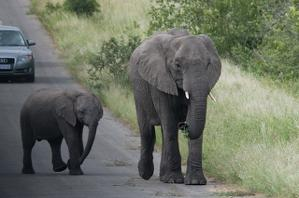

/content/thumbnails/COCO_train2014_000000271395.jpg


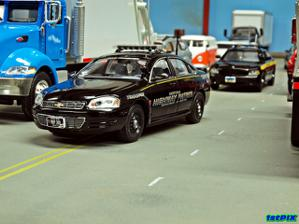

/content/thumbnails/COCO_train2014_000000138585.jpg


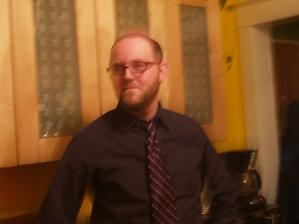

In [0]:
#display images each
train_image_path = absolute_path[random.choice(training_set)[-1]]
validation_image_path = absolute_path[random.choice(validation_set)[-1]]
test_image_path = absolute_path[random.choice(test_set)[-1]]
# print(absolute_path[random.choice(training_set)[-1]])
to_display = [train_image_path, validation_image_path, test_image_path]
for i in to_display:
  print(i)
  display.display(display.Image(i))



### Forward your images through InceptionV3, and cache activations to disk

Rather than training a CNN from scratch for your VQA model, you'll begin by using activations from a pretrained model.  

* Instead of forward each image repeatedly through the model while training (which will be slow), let's do that once and save the activations to disk. 

* We're saving them to disk (rather than keeping them in memory) to accomodate different sizes of datasets down the road.

I've written a good deal of this code for you, but you should go through it and carefully understand how it works.

In [0]:
# Create a feature extraction model.
# You should not need to modify this (though you may, if you'd like
# to use a model other than Inception).
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 3s 0us/step


In [0]:
# A method to load an image off disk, and extract activations using 
# the model above. You should not need to modify this.
def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations, image_path

In [0]:
# Your code here

# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images 
# (image_path_set). Populate this with the absolute paths to all these images.
image_path_set = set()
for img in training_set:
  image_path_set.add(absolute_path[img[-1]])
for img in validation_set:
  image_path_set.add(absolute_path[img[-1]])
for img in test_set:
  image_path_set.add(absolute_path[img[-1]])

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 9656
This make take a few minutes


In [0]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. You should not need to modify this.

# Note: we're not saving these activations to the cloud,
# but you certainly could if you wanted to skip this step 
# in the future. If you look into doing that, it's best to save one large
# zip with the activations, and download that and extract it locally
# (rather than doing a bunch of network access to retrieve individual files),
# especially when training your model.

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy()) 

### Create lists of questions, answers, and images for your train, validation, and test set

At this point, you may be reading your starter CSV directly from disk, or you may have your own data structure in memory. Since many of the methods we'll call from this point forward take lists as input, you may find it helpful to create a data structure with three lists, that correspond to the columns from your starter CSV.

In [0]:
questions_train = [i[0] for i in training_set] # a list of questions in your training set
answers_train = [convert_answer[i[1]] for i in training_set]# a list of answers (in numeric format) in your training set 
images_train = [absolute_path[i[2]] for i in training_set] # a list of absolute paths to images in your training set

In [0]:
questions_val = [i[0] for i in validation_set] 
answers_val = [convert_answer[i[1]] for i in validation_set]
images_val = [absolute_path[i[2]] for i in validation_set]

In [0]:
questions_test = [i[0] for i in test_set] 
answers_test = [convert_answer[i[1]] for i in test_set]
images_test = [absolute_path[i[2]] for i in test_set]

### Create and fit a tokenizer

Your model will use a LSTM to process the questions. First, you'll need to vectorize your text. Tokenize the questions, and limit the vocabulary size to a reasonable size (for example, the top 3,000 words). A larger size will make a higher accuracy possible, but complicate and slow your model. Reminder: fit the tokenizer only on the training questions.

In [0]:
VOCAB_SIZE = 3000

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions_train)

In [0]:
print("Word index", len(tokenizer.word_index))

Word index 4734


### Vectorize the questions
In this section, you will use your tokenizer to vectorize the questions using ```texts_to_sequences```. For an example of texts_to_sequences, see this [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-one-hot-encoding-of-words-or-characters.ipynb).


In [0]:
sequences_train = tokenizer.texts_to_sequences(questions_train)
sequences_val = tokenizer.texts_to_sequences(questions_val)
sequences_test = tokenizer.texts_to_sequences(questions_test)
# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 4734 unique tokens.


### Pad sequences

In this section, you will pad the vectorized questions using ```pad_sequences```. Your maximum sequence length is a design decision, just like vocab size. Advice, start with something short, so your model trains faster (maybe, between 10 and 20).

For an example of pad_sequences, see this [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb).

In [0]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [0]:
def count_words(str):
  count = 1
  for i in str:
    if i.isspace():
      count += 1
  return count

In [0]:
question_word_count = []
for question in questions_train:
  question_word_count.append(count_words(question))
max_word = max(question_word_count)
print(max_word)

20


Here I get max question length is 20, so I choose MAX_SEQ_LEN = 20

In [0]:
max_features = 10000  # number of words to consider as features
MAX_SEQ_LEN = 20 # cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [0]:
print('Pad sequences')

padded_train = sequence.pad_sequences(sequences_train, maxlen = MAX_SEQ_LEN)
padded_val = sequence.pad_sequences(sequences_val, maxlen = MAX_SEQ_LEN)
padded_test = sequence.pad_sequences(sequences_test, maxlen = MAX_SEQ_LEN)
print('padded_train shape:', padded_train.shape)
print('padded_val shape:', padded_val.shape)
print('padded_test shape:', padded_test.shape)

Pad sequences
padded_train shape: (16000, 20)
padded_val shape: (4000, 20)
padded_test shape: (4000, 20)


### Sanity check
You've just done a **bunch** of preprocessing. Optionally, now would be a good time to write a block of code to verify the tokenized and padded sequences are in the format you expect.

In [0]:
#convert from a vectorized question back to a string.
reverse_word = dict(map(reversed, tokenizer.word_index.items()))

def sequence_text(indices):
  words = [reverse_word.get(letter) for letter in indices]
  return words

for item in sequences_train[3:6]:
  print(item)
  texts = list(map(sequence_text, [item]))
  print(texts)

[1, 2, 340, 300]
[['is', 'the', 'banana', 'closed']]
[1, 2, 33, 352]
[['is', 'the', 'water', 'dirty']]
[5, 39, 2, 81, 131, 8]
[['are', 'all', 'the', 'street', 'lights', 'on']]


### Create a tf.dataset for training, validation, and testing

The method to create the dataset is provided for you, though you will need to get it working by passing the ```padded_train```, ```answers_train``` ```and images_train``` lists you created above.




In [0]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def load_np(img_path, question, answer):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, question, answer, img_path

# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of padded questions
# - a batch of numeric answers
# - a batch of absolute paths to the corresponding images
def create_dataset(images, sequences, answers):
  dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                sequences, 
                                                answers))
  # TODO jbgordon@: rewrite this to be clearer
  # Load the cached activations off disk
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.int32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

# Call the above method to create train, val, and test datasets.
train_ds = create_dataset(images_train, padded_train, answers_train)
val_ds = create_dataset(images_val, padded_val, answers_val)
test_ds = create_dataset(images_test, padded_test, answers_test)

### Sanity check (optional)
That dataset creation method is complicated. Write a block of code that demonstrates how to use the dataset (e.g., retrieve a batch of activations, questions, answeres, and images paths) and verify they look as expected.

In [0]:
my_iterator = iter(train_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      questions_batch.shape, 
      answers_batch.shape, 
      paths_batch.shape)

(32, 8, 8, 2048) (32, 20) (32,) (32,)


In [0]:
my_iterator = iter(val_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      questions_batch.shape, 
      answers_batch.shape, 
      paths_batch.shape)

(32, 8, 8, 2048) (32, 20) (32,) (32,)


In [0]:
my_iterator = iter(test_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      questions_batch.shape, 
      answers_batch.shape, 
      paths_batch.shape)

(32, 8, 8, 2048) (32, 20) (32,) (32,)


### Define your VQA model

You can base your code off the example give toward bottom of this [guide](https://keras.io/getting-started/functional-api-guide/) (but use a smaller model to start). Aim for a couple hundred thousand parameters or so

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.models import Model, Sequential

In [0]:
# Input to your vision model (activations from Inception-V3,
# loaded off disk disk by the dataset above).
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 

# Write your test processing model that takes the vectorized and padded
# question as input.
question_input = Input(shape=(20,), dtype='int32')
embedded_question = Embedding(input_dim=4737, output_dim=256, input_length=100)(question_input)
encoded_question = LSTM(256)(embedded_question)

merged = tf.keras.layers.concatenate([encoded_image, encoded_question])
#add a small dense layer
output = Dense(8, activation='relu')(merged)

output = Dense(1, activation='sigmoid')(output)
#final model
model = Model(inputs=[image_input, question_input], outputs=output)

In [0]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 20, 256)      2560000     input_21[0][0]                   
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 2048)         0           input_20[0][0]                   
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Plot your model
Create a schematic that shows the graph of your model, using [plot_model](https://keras.io/visualization/). This can be helpful to ensure the vision and question paths look at expected (it's also super cool, and more informative than .summary).

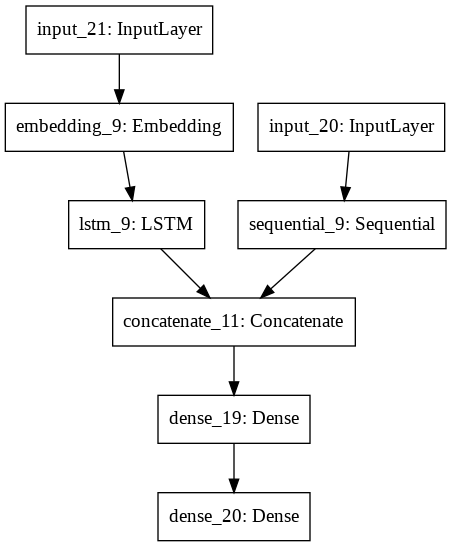

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Fit your model on a single batch
Before training on your entire dataset, a helpful first step is to train repeatedly on a single batch, and verify the loss goes to zero. If your model is working properly, it should be able to memorize a batch of data. We will use ```model.train_on_batch``` for this.

In [0]:
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))
input_batch = [activations_batch, questions_batch, answers_batch, paths_batch]

In [0]:
Epoch = 30
for i in range(Epoch):
  loss, accuracy = model.train_on_batch(x=[activations_batch, questions_batch], y = answers_batch)
  print('Epoch:',i, ' loss:', loss, 'accuracy:', accuracy)

Epoch: 0  loss: 0.7019577 accuracy: 0.5625
Epoch: 1  loss: 0.6512777 accuracy: 0.625
Epoch: 2  loss: 0.6127236 accuracy: 0.71875
Epoch: 3  loss: 0.5679769 accuracy: 0.90625
Epoch: 4  loss: 0.53083396 accuracy: 0.90625
Epoch: 5  loss: 0.4973626 accuracy: 0.875
Epoch: 6  loss: 0.46153435 accuracy: 0.875
Epoch: 7  loss: 0.4235386 accuracy: 0.96875
Epoch: 8  loss: 0.3898171 accuracy: 1.0
Epoch: 9  loss: 0.35759342 accuracy: 1.0
Epoch: 10  loss: 0.32463694 accuracy: 1.0
Epoch: 11  loss: 0.29002202 accuracy: 1.0
Epoch: 12  loss: 0.2610746 accuracy: 1.0
Epoch: 13  loss: 0.23556548 accuracy: 1.0
Epoch: 14  loss: 0.20972154 accuracy: 1.0
Epoch: 15  loss: 0.18309641 accuracy: 1.0
Epoch: 16  loss: 0.16055514 accuracy: 1.0
Epoch: 17  loss: 0.13952354 accuracy: 1.0
Epoch: 18  loss: 0.11925569 accuracy: 1.0
Epoch: 19  loss: 0.1039913 accuracy: 1.0
Epoch: 20  loss: 0.08616849 accuracy: 1.0
Epoch: 21  loss: 0.07418019 accuracy: 1.0
Epoch: 22  loss: 0.060608353 accuracy: 1.0
Epoch: 23  loss: 0.05117633

### Use your model to make predictions on the same batch above
Compare the predicted answer to the label. Verify they match.

In [0]:
for prediction, answer in zip(model.predict(x=[activations_batch, questions_batch]), answers_batch):
  print(prediction, answer.numpy())

[0.98470396] 1.0
[0.00286964] 0.0
[0.9889512] 1.0
[0.00509921] 0.0
[0.00467473] 0.0
[0.00238535] 0.0
[0.00840965] 0.0
[0.03488377] 0.0
[0.99657345] 1.0
[0.01749104] 0.0
[0.9955221] 1.0
[0.9921366] 1.0
[0.00259396] 0.0
[0.07342112] 0.0
[0.00193048] 0.0
[0.00645542] 0.0
[0.00386098] 0.0
[0.99296725] 1.0
[0.0067988] 0.0
[0.9669404] 1.0
[0.00279403] 0.0
[0.9870454] 1.0
[0.9770398] 1.0
[0.02572849] 0.0
[0.9783213] 1.0
[0.02176148] 0.0
[0.9971376] 1.0
[0.9964632] 1.0
[0.97437423] 1.0
[0.00469077] 0.0
[0.01951024] 0.0
[0.9738732] 1.0


### Create a checkpoints directory

Once you have been able to train your model on a single batch, it's time to begin training on your training dataset. It may take a while to train for a single epoch, and it would be unfortunate if Colab disconnected after training for a while, and you lost your progress.

* After each training epoch, save the model's weights in a checkpoint file. You can learn more about how to create checkpoints [here](https://www.tensorflow.org/guide/keras/save_and_serialize). 

* To resume training, load the latest checkpoint from disk. This will restore the latest weights and resume your progress. If it does not exist, begin training from scratch.

* As a tip, you may want to store your checkpoints in Google Drive, so you'll still have access to them if Colab disconnects. 

Note that running long jobs is not what Colab is intended for. Normally, you could simple save your checkpoints on the machine you're working on. Saving to drive adds an extra step, but it's worthwhile learning how to do.

Tip: after mounting Drive, **do not** programmatically run any commands to delete files from your checkpoints folder or elsewhere (e.g., by using ```!rm -rf```) in Colab. If you're not careful, you may accidentally wipe out your entire drive if you make a programming mistake. 

* Instead, if you need to delete checkpoints, do so manually through the drive user interface. Note that files deleted through the UI may take a minute or so to "actually" be deleted as reflected by ```!ls``` commands run from Colab.

In [0]:
# Mount drive
drive.mount('/content/gdrive')
drive_root = '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "hw4")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [0]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /content/gdrive/My Drive/checkpoints/hw4
Checkpoints folder already exists


###Restore the latest checkpoint (if it exists).

In [0]:
# You should not need to modify this code.
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


###Metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

###Code to evaluate on the validation dataset

In [0]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

### Train the model
As before, we'll write our training loop using ```train_on_batch```. This is intermediate in complexity between using ```.fit``` and writing everything from scratch using a ```GradientTape```. Because we're not using ```.fit```. Since we're not using .fit, there's a bit of extra code we need to write ourselves to track loss and accuracy as we go.

In [0]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  model.save_weights('/content/gdrive/My Drive/checkpoints/hw4')

Epoch 0, Loss: 0.73, Accuracy: 50.84, Val Loss 0.69, Val Accuracy 53.03, Time: 101.4 secs
Saving weights
Epoch 1, Loss: 0.67, Accuracy: 57.82, Val Loss 0.70, Val Accuracy 53.00, Time: 98.7 secs
Saving weights
Epoch 2, Loss: 0.64, Accuracy: 62.69, Val Loss 0.72, Val Accuracy 53.69, Time: 98.7 secs
Saving weights
Epoch 3, Loss: 0.61, Accuracy: 65.49, Val Loss 0.78, Val Accuracy 53.12, Time: 99.0 secs
Saving weights
Epoch 4, Loss: 0.57, Accuracy: 68.88, Val Loss 0.80, Val Accuracy 52.94, Time: 98.2 secs
Saving weights
Epoch 5, Loss: 0.53, Accuracy: 71.43, Val Loss 0.84, Val Accuracy 53.09, Time: 99.6 secs
Saving weights
Epoch 6, Loss: 0.50, Accuracy: 73.78, Val Loss 0.92, Val Accuracy 51.75, Time: 97.4 secs
Saving weights
Epoch 7, Loss: 0.47, Accuracy: 75.31, Val Loss 0.98, Val Accuracy 52.41, Time: 97.9 secs
Saving weights
Epoch 8, Loss: 0.45, Accuracy: 77.21, Val Loss 1.05, Val Accuracy 52.41, Time: 97.4 secs
Saving weights
Epoch 9, Loss: 0.43, Accuracy: 77.86, Val Loss 1.07, Val Accura

###Create plots of your training and validation loss and accuracy

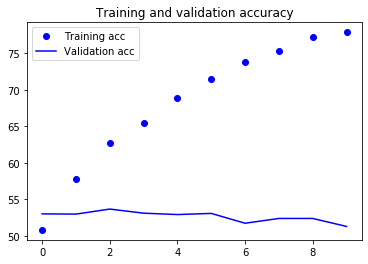

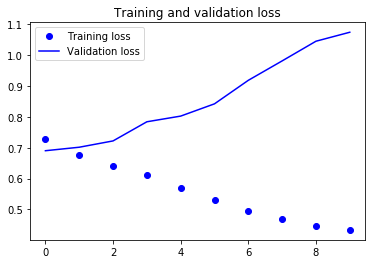

In [0]:
acc = train_acc_history
val_acc = val_acc_history
loss = train_loss_history
val_loss = val_loss_history

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Run one experiment to improve accuracy

Here I add one more relu dense layer and increase the nodes. And I run the same 10 epochs in a batch size. And it turned out that my what I have done get paid off. The loss decreased and the accuracy improved.

In [0]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 

# Write your test processing model that takes the vectorized and padded
# question as input.
question_input = Input(shape=(20,), dtype='int32')
embedded_question = Embedding(input_dim=4737, output_dim=256, input_length=100)(question_input)
encoded_question = LSTM(256)(embedded_question)

merged = tf.keras.layers.concatenate([encoded_image, encoded_question])
#add two dense layers
output = Dense(128, activation='relu')(merged)
output = Dense(32, activation='relu')(output)
output = Dense(1, activation='sigmoid')(output)
#final model
model = Model(inputs=[image_input, question_input], outputs=output)

In [0]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 20, 256)      2560000     input_23[0][0]                   
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 2048)         0           input_22[0][0]                   
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [0]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  model.save_weights('/content/gdrive/My Drive/checkpoints/hw4')

Epoch 0, Loss: 0.68, Accuracy: 55.39, Val Loss 0.70, Val Accuracy 53.09, Time: 103.3 secs
Saving weights
Epoch 1, Loss: 0.64, Accuracy: 62.51, Val Loss 0.73, Val Accuracy 53.41, Time: 101.8 secs
Saving weights
Epoch 2, Loss: 0.60, Accuracy: 67.32, Val Loss 0.75, Val Accuracy 54.12, Time: 104.4 secs
Saving weights
Epoch 3, Loss: 0.55, Accuracy: 70.59, Val Loss 0.81, Val Accuracy 53.47, Time: 111.4 secs
Saving weights
Epoch 4, Loss: 0.51, Accuracy: 72.86, Val Loss 0.90, Val Accuracy 53.84, Time: 112.9 secs
Saving weights
Epoch 5, Loss: 0.48, Accuracy: 74.89, Val Loss 0.95, Val Accuracy 54.22, Time: 110.6 secs
Saving weights
Epoch 6, Loss: 0.46, Accuracy: 76.43, Val Loss 1.01, Val Accuracy 53.91, Time: 108.2 secs
Saving weights
Epoch 7, Loss: 0.43, Accuracy: 78.03, Val Loss 1.22, Val Accuracy 53.59, Time: 105.1 secs
Saving weights
Epoch 8, Loss: 0.41, Accuracy: 79.27, Val Loss 1.10, Val Accuracy 53.84, Time: 106.9 secs
Saving weights
Epoch 9, Loss: 0.39, Accuracy: 80.11, Val Loss 1.21, Va

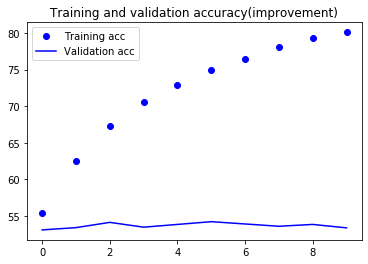

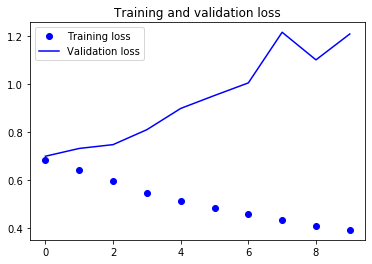

In [0]:
acc = train_acc_history
val_acc = val_acc_history
loss = train_loss_history
val_loss = val_loss_history

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(improvement)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Finally, evaluate your model on the test set

In [0]:
# Restore the latest checkpoint
checkpoint_dir = os.path.join(drive_root, "checkpoints")
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from /content/gdrive/My Drive/checkpoints/hw4


In [0]:
val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [0]:
for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    predictions = model.predict(x=[activation_batch, question_batch])
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)
template = 'test Loss {:.2f}, test Accuracy {:.2f}'
print(template.format(val_loss.result(),val_accuracy.result() * 100))

test Loss 1.19, test Accuracy 53.66


I find that the test accuracy is pretty bad because of overfit. It is a result of the small size of the dataset. So, train the model in a big dataset is the basic way to solve overfit.